In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.parameters import ANIMALS
from loren_frank_data_processing import make_epochs_dataframe
from loren_frank_data_processing import make_neuron_dataframe
from loren_frank_data_processing import get_position_dataframe
from loren_frank_data_processing import get_spikes_dataframe

epoch_info = make_epochs_dataframe(ANIMALS)

epoch_key = ('HPa', 3, 2) # animal, day, epoch
position_info = get_position_dataframe(epoch_key, ANIMALS)

Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [2]:
position_info['time_sec'] = position_info.index / np.timedelta64(1, 's')

In [3]:
neuron_info = make_neuron_dataframe(ANIMALS)
neuron_info = neuron_info.xs(epoch_key, drop_level=False)

In [48]:
## try to bin it
position_info['linear_position_binned'] = position_info['linear_position'] // 2

In [49]:
def get_position_info_indices_at_spikes(spike_times_sec, position_info):
    '''
    spike_times_sec must be the times in seconds
    position_info must be modified to have a 'time_sec' column with corresponding units to spike_times_sec
    '''
    time_indices = np.empty((spike_times_sec.shape[0]), dtype='int')

    spike_time_index = 0

    for i, spike_time in enumerate(spike_times_sec):
        for index in range(spike_time_index, position_info['time_sec'].shape[0]):
            prev_index = max(0, index-1)
            prev_pos_time = position_info['time_sec'][prev_index]
            pos_time = position_info['time_sec'][index]
            # if we have gone too far
            if pos_time > spike_time:
                spike_time_index = prev_index
                break
        # time_ind (where to index into positions table)
        time_indices[i] = spike_time_index
    return time_indices

In [50]:
def get_combined_dataframe(neuron_info, position_info):
    '''
    Combines all spikes from different neurons with associated position information
    
    Does some copying.
    '''
    # this happens on single core
    df = pd.DataFrame()

    for neuron_idx in range(neuron_info.index.shape[0]):
        neuron_area = neuron_info.iloc[neuron_idx]['area']
        neuron_id = neuron_info.iloc[neuron_idx]['neuron_id']

        spike_times = get_spikes_dataframe(neuron_info.index[neuron_idx], ANIMALS)
        spike_times_sec = spike_times.index / np.timedelta64(1, 's')
        time_indices = get_position_info_indices_at_spikes(spike_times_sec, position_info)

        spike_position_info = position_info.iloc[time_indices].copy()
        spike_position_info['neuron_idx'] = neuron_idx
        spike_position_info['neuron_area'] = neuron_area
        spike_position_info['neuron_id'] = neuron_id
        
        # technically inaccurate, but helps with frequency
        spike_position_info['time_sec'] = spike_times_sec

        df = df.append(spike_position_info)
    return df


In [51]:
class AdditiveHistogram():
    def __init__(self):
        self.hist = {}
    
    def add(self, key, increment):
        if key in self.hist.keys():
            self.hist[key] += increment
        else:
            self.hist[key] = increment
        
    def get(self, key):
        if key in self.hist.keys():
            return self.hist[key]
        else:
            return 0
        
    def values(self):
        bins, values = np.array([x for x in self.hist.keys()]), np.array([x for x in self.hist.values()])
        idx = np.argsort(bins)
        return bins[idx], values[idx]

In [55]:
combined_info = get_combined_dataframe(neuron_info, position_info)

In [56]:
df = combined_info

In [57]:
df.columns

Index(['x_position', 'y_position', 'head_direction', 'speed',
       'linear_distance', 'projected_x_position', 'projected_y_position',
       'track_segment_id', 'arm_name', 'labeled_segments', 'from_well',
       'to_well', 'task', 'is_correct', 'turn', 'linear_position',
       'linear_velocity', 'linear_speed', 'time_sec', 'linear_position_binned',
       'neuron_idx', 'neuron_area', 'neuron_id'],
      dtype='object')

In [58]:
df = df[(df.neuron_area == 'CA1') & (df.neuron_id == 'HPa_03_02_001_002')]

In [116]:
variations = []

for i in range(1000):
    idx = np.random.choice(position_info.index, size = len(position_info.index), replace=True )
    bootstrap_pos = position_info.loc[idx,:]

    occupancy = AdditiveHistogram()

    for i, e in enumerate(bootstrap_pos['linear_position_binned']):
        occupancy.add(e, 0.033399999999801366)

    occupancy_bins, occupancy_secs = occupancy.values()

    variations.append((occupancy_bins, occupancy_secs))



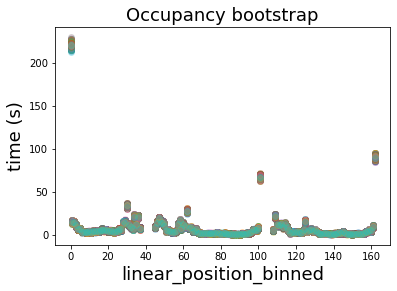

In [119]:
plt.title('Occupancy bootstrap', fontsize=18)
plt.xlabel('linear_position_binned', fontsize=18)
plt.ylabel('time (s)', fontsize=18)


for occupancy_bins,occupancy_secs in variations:
    plt.scatter(occupancy_bins, occupancy_secs, alpha=0.25)

plt.savefig('../figures/occupancy_bootstrap.png')

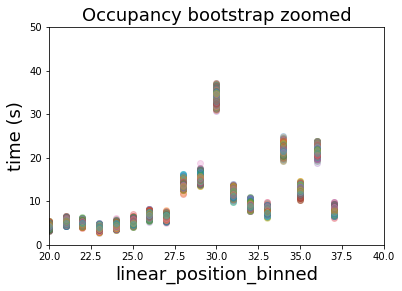

In [120]:
plt.title('Occupancy bootstrap zoomed', fontsize=18)
plt.xlabel('linear_position_binned', fontsize=18)
plt.ylabel('time (s)', fontsize=18)

plt.xlim(20,40)
plt.ylim(0,50)

for occupancy_bins,occupancy_secs in variations:
    plt.scatter(occupancy_bins, occupancy_secs, alpha=0.25)
plt.savefig('../figures/occupancy_bootstrap_zoomed.png')

In [187]:
def run_bootstrap(df, position_info):
    frequencyBootstrap = []

    # this is so slow... it's a single core
    for i in range(100):
        idx = np.random.choice(position_info.index, size = len(position_info.index), replace=True )
        bootstrap_pos = position_info.loc[idx,:]

        occupancy = AdditiveHistogram()

        for i, e in enumerate(bootstrap_pos['linear_position_binned']):
            occupancy.add(e, 0.033399999999801366)

        occupancy_bins, occupancy_secs = occupancy.values()

        filtered_idx = filter(lambda x: x in df.index, idx)
        filtered_df = df.loc[filtered_idx, :]

        spikes = AdditiveHistogram()

        for i, e in enumerate(filtered_df['linear_position_binned']):
            spikes.add(e, 1)

        spikes_bins, spikes_counts = spikes.values()
        spikes_frequencies = np.array([scount / occupancy.get(sbin) for (sbin, scount) in zip(spikes_bins, spikes_counts)])


        frequencyBootstrap.append((spikes_bins, spikes_frequencies))

    return frequencyBootstrap

In [184]:
def plot_pretty_occupancy_normalized_histogram_with_ci_lines(frequencyBootstrap):
    bin_dict = {}
    for spikes_bins, spikes_frequencies in frequencyBootstrap:
        for i, e in enumerate(spikes_bins):
            if e in bin_dict:
                bin_dict[e].append(spikes_frequencies[i])
            else:
                bin_dict[e] = [spikes_frequencies[i]]
    
    # aggregate results
    mean_ci = np.empty((len(bin_dict), 4)) # bin, mean, ci_low, ci_high
    for i, k in enumerate(bin_dict):
        array = np.array(bin_dict[k])
        mean = array.mean()
        ci_low, ci_high = np.quantile(array, [0.025, 1-0.025])
        mean_ci[i,:] = [k, mean, ci_low, ci_high]
    # sort so it plotting lines works out
    mean_ci_idx = np.argsort(mean_ci[:, 0])
    mean_ci = mean_ci[mean_ci_idx]
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    fig, ax = plt.subplots()
    
    ax.set_title('occupancy normalized activity versus position (HPa_03_02_001_002)', fontsize=18)
    ax.set_xlabel('linear_position_binned', fontsize=18)
    ax.set_ylabel('spikes per second', fontsize=18)

    ax.plot(mean_ci[:, 0], mean_ci[:,1], alpha=0.25)
    ax.plot(mean_ci[:, 0], mean_ci[:,2], color=colors[1], linestyle='--', alpha=0.25)
    ax.plot(mean_ci[:, 0], mean_ci[:,3], color=colors[1], linestyle='--', alpha=0.25)

    ax.fill_between(mean_ci[:, 0], mean_ci[:,2], mean_ci[:,3], color=colors[1], alpha=0.05)
    return fig, ax


In [188]:
df = combined_info
df = df[(df.neuron_area == 'CA1') & (df.neuron_id == 'HPa_03_02_001_002')]

frequencyBootstrap = run_bootstrap(df, position_info)

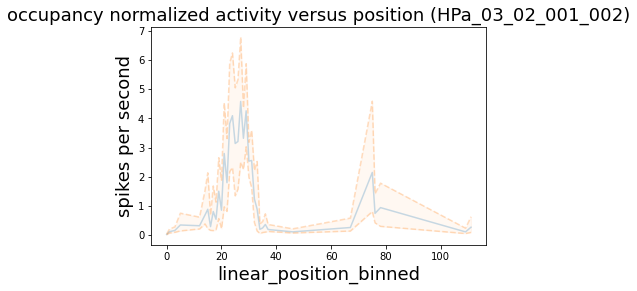

In [189]:
fig, ax = plot_pretty_occupancy_normalized_histogram_with_ci_lines(frequencyBootstrap)

fig.savefig('../figures/occupancy_normalized_activity_versus_position.png')
fig.show()

In [191]:
df = combined_info
neuron_ids_ca1 = df[df.neuron_area == 'CA1']['neuron_id'].unique()

In [ ]:
for neuron_id in neuron_ids_ca1:
    df_neuron = df[df.neuron_id == neuron_id]
    
    frequencyBootstrap = run_bootstrap(df_neuron, position_info)
    fig, ax = plot_pretty_occupancy_normalized_histogram_with_ci_lines(frequencyBootstrap)
    ax.set_ylim(0, 15)
    ax.set_xlim(-5, 170)
    fig.savefig('../figures/neuron{0}_occupancy_normalized_histogram_with_ci_lines.png'.format(neuron_id))
    fig.show()


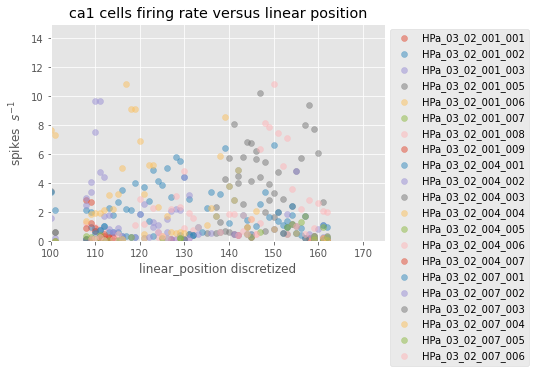

In [134]:
plt.title("ca1 cells firing rate versus linear position")
plt.ylim(0, 15)
plt.xlim(100, 175)
plt.xlabel('linear_position discretized')
plt.ylabel('spikes  $s^{-1}$')

neuron_firing_rate_max = {}

for neuron_id in neuron_ids_ca1:
    df_neuron = df[df.neuron_id == neuron_id]
    
    spikes = AdditiveHistogram()
    for i, e in enumerate(df_neuron['linear_position_binned']):
        spikes.add(e, 1)
    spikes_bins, spikes_counts = spikes.values()
    spikes_frequencies = np.array([scount / occupancy.get(sbin) for (sbin, scount) in zip(spikes_bins, spikes_counts)])
    plt.scatter(spikes_bins, spikes_frequencies, alpha=0.5, label=neuron_id)
    
    neuron_firing_rate_max[neuron_id] = spikes_frequencies.max()

plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig('../figures/all_cells.png')
plt.show()


In [143]:
ca1_neurons = neuron_info[(neuron_info['area'] == 'CA1') & (neuron_info['neuron_id'] != 'HPa_03_02_001_004')]

In [146]:
ca1_neurons['max_firing_rate'] = [neuron_firing_rate_max[neuron_id] for neuron_id in ca1_neurons['neuron_id']]

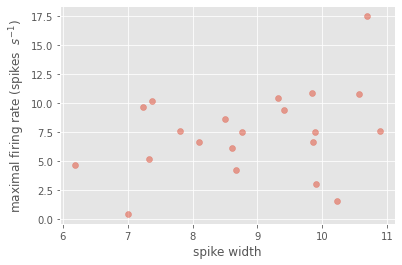

In [151]:
plt.scatter(ca1_neurons['spikewidth'], ca1_neurons['max_firing_rate'], alpha=0.5)
plt.xlabel('spike width')
plt.ylabel('maximal firing rate (spikes  $s^{-1}$)')
plt.savefig('../figures/spikewidth_firing_rates.png')
None